# **Mô hình Random Forest dự đoán giá cà phê**

# Khai báo thư viện

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# **Khám phá các bộ dữ liệu**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Weather_GL = pd.read_excel("/content/drive/MyDrive/cà phê/GiaLai.xlsx")
Weather_GL = Weather_GL[:-4]

In [ ]:
Weather_GL.rename(columns = {"date":"Date"}, inplace = True)
Weather_GL = Weather_GL[["Date","tavg","prcp"]]

In [ ]:
Weather_GL['Date'] = pd.to_datetime(Weather_GL['Date'])
Weather_GL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1182 entries, 0 to 1181
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1182 non-null   datetime64[ns]
 1   tavg    1180 non-null   float64       
 2   prcp    1180 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 27.8 KB


<ipython-input-6-8cd8b0650f3e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Weather_GL['Date'] = pd.to_datetime(Weather_GL['Date'])


In [ ]:
Weather_GL

,Date,tavg,prcp
0,2021-01-02,18.1,0.0
1,2021-01-03,19.4,0.0
2,2021-01-04,20.9,0.0
3,2021-01-05,21.0,0.0
4,2021-01-06,20.4,0.0
...,...,...,...
1177,2024-03-24,25.8,0.1
1178,2024-03-25,25.5,0.2
1179,2024-03-26,25.0,0.0
1180,2024-03-27,25.2,0.2


In [ ]:
Ex_rate = pd.read_excel("/content/drive/MyDrive/cà phê/tygia.xlsx")
Ex_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1012 entries, 0 to 1011
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1012 non-null   datetime64[ns]
 1   Price     1012 non-null   float64       
 2   Open      1012 non-null   float64       
 3   High      1012 non-null   float64       
 4   Low       1012 non-null   float64       
 5   Vol.      0 non-null      float64       
 6   Change %  1012 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 55.5 KB


In [ ]:
Ex_rate = Ex_rate[["Date","Price"]]
Ex_rate

,Date,Price
0,2024-03-28,0.000040
1,2024-03-27,0.000040
2,2024-03-26,0.000040
3,2024-03-25,0.000040
4,2024-03-24,0.000040
...,...,...
1007,2021-01-08,0.000043
1008,2021-01-07,0.000043
1009,2021-01-06,0.000043
1010,2021-01-05,0.000043


In [ ]:
Price_borusta = pd.read_excel("/content/drive/MyDrive/cà phê/price.xlsx")
Price_borusta = Price_borusta[["Date","Price"]]

In [ ]:
Price_borusta

,Date,Price
0,2024-03-28,3479
1,2024-03-27,3559
2,2024-03-26,3465
3,2024-03-25,3417
4,2024-03-22,3465
...,...,...
812,2021-01-08,1318
813,2021-01-07,1336
814,2021-01-06,1356
815,2021-01-05,1365


In [ ]:
Price_oil = pd.read_excel("/content/drive/MyDrive/cà phê/oil.xlsx")
Price_oil.dropna(inplace = True)

In [ ]:
Price_oil = Price_oil[["Date","Price"]]

In [ ]:
Price_oil

,Date,Price
1,2024-03-28,817.00
2,2024-03-27,813.50
3,2024-03-26,817.50
4,2024-03-25,816.75
5,2024-03-22,823.75
...,...,...
833,2021-01-08,447.25
834,2021-01-07,439.75
835,2021-01-06,438.00
836,2021-01-05,434.50


**Gộp các cột dữ liệu cần thiết cho bài dự báo**

In [ ]:
data = Weather_GL.merge(Price_oil, on='Date', how = "outer")
data = data.merge(Ex_rate, on='Date', how = "outer")
data = data.merge(Price_borusta, on = "Date", how = "outer")
data.rename(columns = {"Price_x":"Price_oil", "Price_y": "Ex_rate","Price":"Price_borusta"}, inplace = True)
data.dropna(inplace = True)

In [ ]:
data

,Date,tavg,prcp,Price_oil,Ex_rate,Price_borusta
2,2021-01-04,20.9,0.0,422.00,0.000043,1372.0
3,2021-01-05,21.0,0.0,434.50,0.000043,1365.0
4,2021-01-06,20.4,0.0,438.00,0.000043,1356.0
5,2021-01-07,20.2,0.0,439.75,0.000043,1336.0
6,2021-01-08,19.5,0.0,447.25,0.000043,1318.0
...,...,...,...,...,...,...
1175,2024-03-22,24.2,0.0,823.75,0.000040,3465.0
1178,2024-03-25,25.5,0.2,816.75,0.000040,3417.0
1179,2024-03-26,25.0,0.0,817.50,0.000040,3465.0
1180,2024-03-27,25.2,0.2,813.50,0.000040,3559.0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 815 entries, 2 to 1181
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           815 non-null    datetime64[ns]
 1   tavg           815 non-null    float64       
 2   prcp           815 non-null    float64       
 3   Price_oil      815 non-null    float64       
 4   Ex_rate        815 non-null    float64       
 5   Price_borusta  815 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 44.6 KB


In [ ]:
data.corr()

,Date,tavg,prcp,Price_oil,Ex_rate,Price_borusta
Date,1.000000,0.077461,-0.096459,0.444197,-0.813664,0.855629
tavg,0.077461,1.000000,0.014424,0.063588,-0.013363,0.093451
prcp,-0.096459,0.014424,1.000000,0.075614,0.107238,-0.063297
Price_oil,0.444197,0.063588,0.075614,1.000000,-0.322265,0.295303
Ex_rate,-0.813664,-0.013363,0.107238,-0.322265,1.000000,-0.566637
Price_borusta,0.855629,0.093451,-0.063297,0.295303,-0.566637,1.000000


**Chuẩn hóa dữ liệu**

In [ ]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[["tavg","prcp","Price_oil","Ex_rate","Price_borusta" ]])
df = pd.DataFrame(scaled_data)

In [ ]:
df.columns = ["tavg","prcp","Price_oil","Ex_rate","Price_borusta"]
df

,tavg,prcp,Price_oil,Ex_rate,Price_borusta
0,0.442623,0.000000,0.000000,0.784461,0.031015
1,0.450820,0.000000,0.013801,0.779449,0.027913
2,0.401639,0.000000,0.017665,0.776942,0.023926
3,0.385246,0.000000,0.019597,0.784461,0.015064
4,0.327869,0.000000,0.027877,0.789474,0.007089
...,...,...,...,...,...
810,0.713115,0.000000,0.443555,0.042607,0.958352
811,0.819672,0.003221,0.435827,0.050125,0.937085
812,0.778689,0.000000,0.436655,0.040100,0.958352
813,0.795082,0.003221,0.432238,0.032581,1.000000


**Các biểu đồ thể hiện xu hướng thay đổi của các biến theo thời gian**

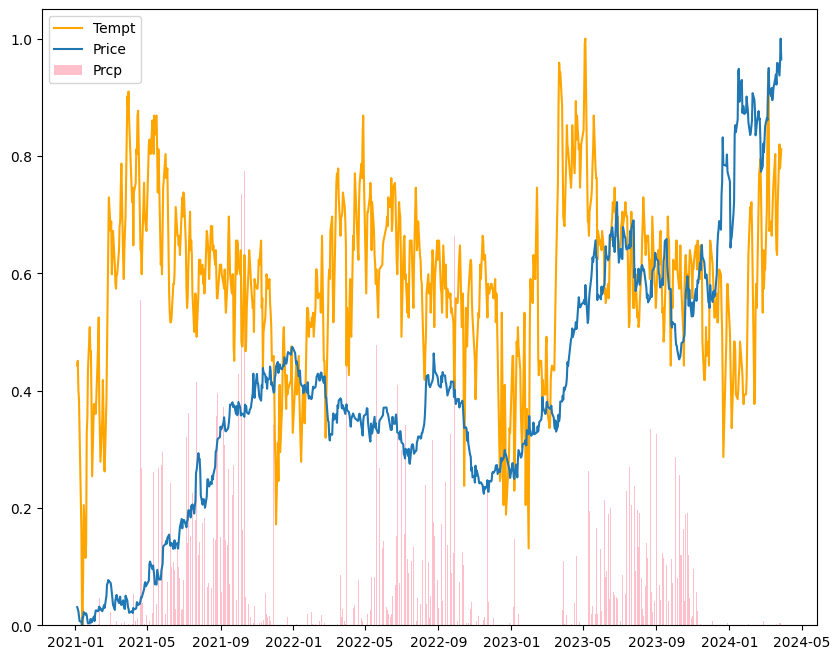

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(data['Date'],df['tavg'], c = 'orange', label = 'Tempt')
plt.plot(data['Date'], df.Price_borusta, label = 'Price')
plt.bar(data['Date'], df.prcp, color = 'pink', label = 'Prcp')
plt.legend()
plt.show()

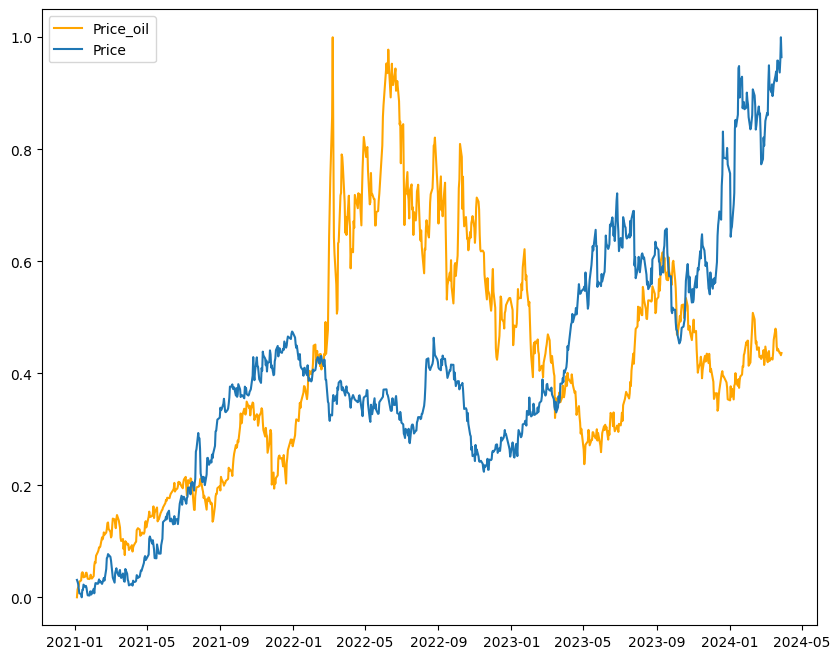

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(data['Date'],df['Price_oil'], c = 'orange', label = 'Price_oil')
plt.plot(data['Date'], df.Price_borusta, label = 'Price')
plt.legend()
plt.show()

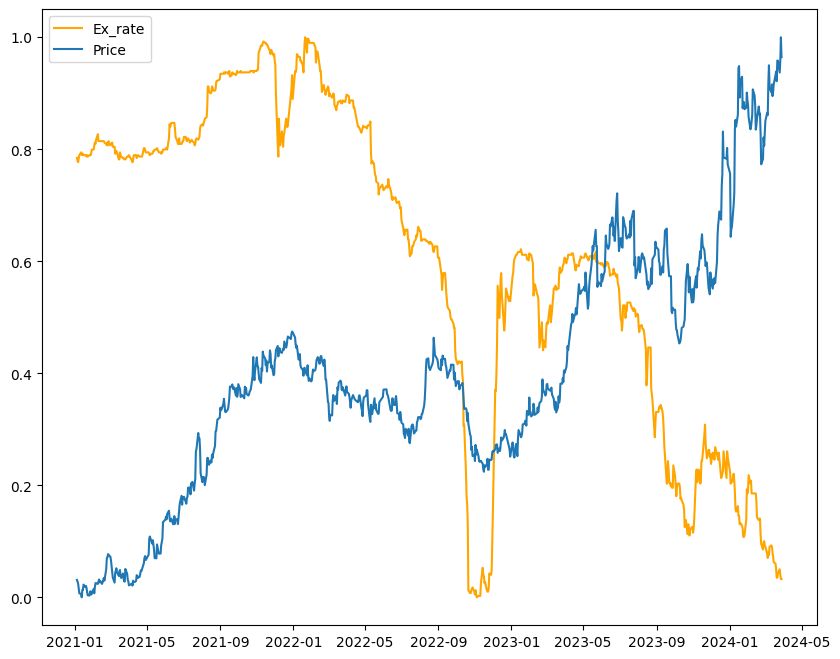

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(data['Date'],df['Ex_rate'], c = 'orange', label = 'Ex_rate')
plt.plot(data['Date'], df.Price_borusta, label = 'Price')

plt.legend()
plt.show()

# **Triển khai mô hình Random Forest**

**Tách dữ liệu để đào tạo**

In [ ]:
X_cols = df[["tavg","prcp","Price_oil","Ex_rate"]]
Y_cols = df["Price_borusta"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_cols, Y_cols, test_size = 0.2, random_state = 0)

**Huấn luyện mô hình**

In [ ]:
model = RandomForestRegressor(n_estimators=100, random_state=0)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

**Dự đoán trên tập kiểm tra**

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
inverse_data_predict = scaler.inverse_transform(np.concatenate((X_test.values, y_pred.reshape(-1, 1)), axis = 1))
inverse_data_predict

array([[2.43000e+01, 3.50000e+00, 6.98750e+02, 4.25000e-05, 2.80422e+03],
       [2.31000e+01, 5.50000e+00, 7.31750e+02, 4.39400e-05, 2.14628e+03],
       [2.31000e+01, 0.00000e+00, 5.16250e+02, 4.33300e-05, 1.39980e+03],
       [2.26000e+01, 0.00000e+00, 8.96250e+02, 4.03900e-05, 1.93983e+03],
       [2.01000e+01, 2.90000e+00, 5.02750e+02, 4.34500e-05, 1.36582e+03],
       [2.08000e+01, 0.00000e+00, 4.52000e+02, 4.33400e-05, 1.33316e+03],
       [2.18000e+01, 2.20000e+00, 1.00275e+03, 4.07300e-05, 2.11487e+03],
       [2.20000e+01, 0.00000e+00, 8.72000e+02, 4.23600e-05, 2.02063e+03],
       [2.03000e+01, 9.00000e-01, 6.48000e+02, 4.35500e-05, 2.29596e+03],
       [2.42000e+01, 0.00000e+00, 8.01750e+02, 4.10100e-05, 2.82597e+03],
       [2.32000e+01, 3.80000e+00, 7.02500e+02, 4.24000e-05, 2.77750e+03],
       [2.28000e+01, 0.00000e+00, 7.76500e+02, 4.10500e-05, 2.99681e+03],
       [1.66000e+01, 0.00000e+00, 4.61750e+02, 4.33600e-05, 1.33935e+03],
       [2.28000e+01, 1.20000e+00, 6.85

In [ ]:
inverse_data_predict = pd.DataFrame(inverse_data_predict,
                   columns=["tavg","prcp","Price_oil","Ex_rate", "y_pred_inverse"])
inverse_data_predict

,tavg,prcp,Price_oil,Ex_rate,y_pred_inverse
0,24.3,3.5,698.75,0.000043,2804.22
1,23.1,5.5,731.75,0.000044,2146.28
2,23.1,0.0,516.25,0.000043,1399.80
3,22.6,0.0,896.25,0.000040,1939.83
4,20.1,2.9,502.75,0.000043,1365.82
...,...,...,...,...,...
158,26.1,0.8,532.25,0.000043,1401.02
159,22.8,0.0,555.00,0.000043,1471.22
160,23.1,6.7,1075.25,0.000043,2207.41
161,20.0,0.0,647.25,0.000044,2300.38


In [ ]:
actual_train, actual_test = train_test_split(data["Price_borusta"], test_size = 0.2, random_state = 0)

In [ ]:
actual_test

899    2807.0
291    2131.0
79     1398.0
696    1859.0
39     1374.0
        ...  
103    1389.0
69     1403.0
606    2250.0
345    2287.0
170    1617.0
Name: Price_borusta, Length: 163, dtype: float64

**Đánh giá mô hình**

In [ ]:
# Đánh giá mô hình bằng Mean Squared Error (MSE)
rmse = mean_squared_error(actual_test, inverse_data_predict["y_pred_inverse"], squared=False)
print(f'Root Mean Squared Error: {rmse}')


Root Mean Squared Error: 175.39007273709623


In [ ]:
# Đánh giá mô hình bằng mean_absolute_error (MAE)
mae = mean_absolute_error(actual_test, inverse_data_predict["y_pred_inverse"])
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 91.90674846625765


In [ ]:
# Đánh giá mô hình bằng R2 scores
R2 = r2_score(y_test, y_pred)
print("R2 = ",R2)

R2 =  0.8862923451227199


Trực quan kết quả

<Axes: >

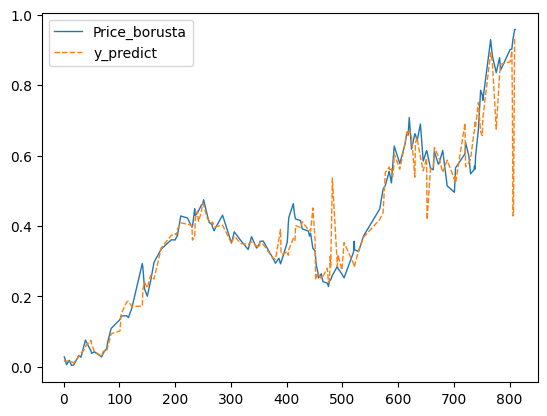

In [ ]:
compare = pd.DataFrame(y_test)
compare["y_predict"]= y_pred
sns.lineplot(data=compare, linewidth=1.0)

# **Tối ưu các tham số**

In [ ]:
# Tối ưu các tham số
# Số cây trong rừng ngẫu nhiên
n_estimators = list(range(200, 2000, 200))

# Số lượng tính năng cần xem xét ở mỗi lần phân chia
max_features = ['auto', 'sqrt', None, 'log2']

# Số cấp độ tối đa trong cây
max_depth = list(range(10, 110, 10))
max_depth.append(None)

# Số lượng mẫu tối thiểu cần thiết để phân chia một nút
min_samples_split = [2, 5, 10, 20, 30, 40]

# Số lượng mẫu tối thiểu cần thiết tại mỗi nút lá
min_samples_leaf = [1, 2, 7, 12, 14, 16 ,20]

# Phương pháp chọn mẫu huấn luyện từng cây
bootstrap = [True, False]

# Tạo lưới ngẫu nhiên
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800], 'max_features': ['auto', 'sqrt', None, 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10, 20, 30, 40], 'min_samples_leaf': [1, 2, 7, 12, 14, 16, 20], 'bootstrap': [True, False]}


In [ ]:
# Công cụ phân loại rừng ngẫu nhiên mới để chứa các thông số tối ưu
rf = RandomForestRegressor()

# Specfiy the details of our Randomized Search
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt', None,
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 7, 12, 14,
                                                             16, 20],
                                        'min_samples_split': [2, 5, 10, 20, 30,
                                                              40],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800]},
                   random_state=42, verbose=2)

**Đánh giá hiệu quả mô hình sau khi tối ưu hóa các siêu tham số**

In [ ]:
print("R2: ", r2_score(y_test,rf_random.predict(X_test) ))

R2:  0.9150261465417201


In [ ]:
inverse_data_predict_optimal = scaler.inverse_transform(np.concatenate((X_test.values, rf_random.predict(X_test).reshape(-1, 1)), axis = 1))
inverse_data_predict_optimal = pd.DataFrame(inverse_data_predict_optimal,
                   columns=["tavg","prcp","Price_oil","Ex_rate", "y_pred_inverse"])
inverse_data_predict_optimal

,tavg,prcp,Price_oil,Ex_rate,y_pred_inverse
0,24.3,3.5,698.75,0.000043,2792.199583
1,23.1,5.5,731.75,0.000044,2135.616458
2,23.1,0.0,516.25,0.000043,1400.309688
3,22.6,0.0,896.25,0.000040,2453.170313
4,20.1,2.9,502.75,0.000043,1464.721458
...,...,...,...,...,...
158,26.1,0.8,532.25,0.000043,1396.109948
159,22.8,0.0,555.00,0.000043,1470.067292
160,23.1,6.7,1075.25,0.000043,2208.348594
161,20.0,0.0,647.25,0.000044,2299.578281


In [ ]:
# Đánh giá mô hình bằng Mean Squared Error (MSE)
rmse = mean_squared_error(actual_test, inverse_data_predict_optimal["y_pred_inverse"], squared=False)
print(f'Root Mean Squared Error: {rmse}')
# Đánh giá mô hình bằng mean_absolute_error (MAE)
mae = mean_absolute_error(actual_test, inverse_data_predict_optimal["y_pred_inverse"])
print(f'Mean Absolute Error: {mae}')

Root Mean Squared Error: 151.61871569342054
Mean Absolute Error: 93.44074865797627


**Trực quan kết quả mô hình sau tối ưu các siêu tham số**

In [ ]:
re = pd.DataFrame(y_test)
re["y_predict"]= rf_random.predict(X_test)

<Axes: >

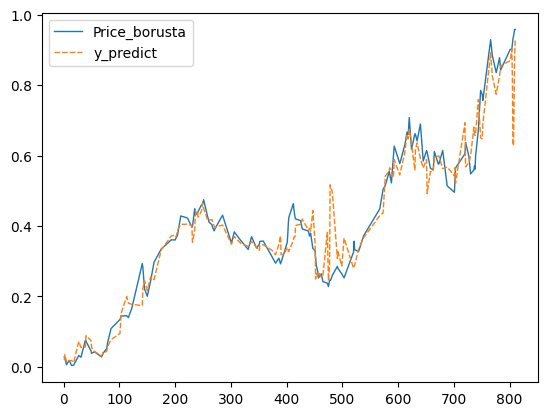

In [ ]:
sns.lineplot(data=re, linewidth=1.0)

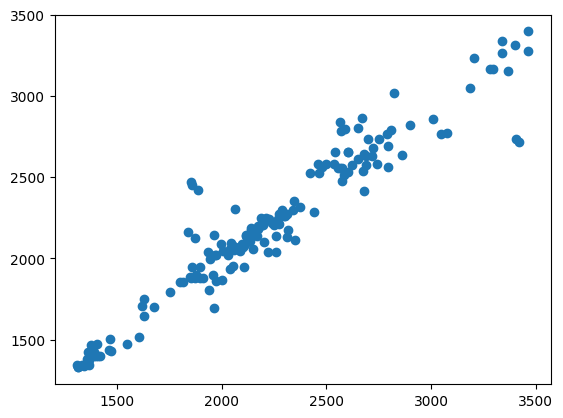

In [ ]:
plt.scatter(actual_test, inverse_data_predict_optimal["y_pred_inverse"])